In [22]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pathlib import Path

In [23]:
IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1)),
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
    transforms.RandomErasing(p = 0.25),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225)),
])

In [ ]:
root_dir   = Path("dataset")
batch_size = 64
num_workers = 4

# Datasets
train_ds = datasets.ImageFolder(root_dir / "train",
                                transform=train_transforms)
val_ds   = datasets.ImageFolder(root_dir / "val",
                                transform=val_test_transforms)
# test_ds  = datasets.ImageFolder(root_dir / "test_extracted",
#                                 transform=val_test_transforms)

# DataLoaders
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                      num_workers=num_workers, pin_memory=True, drop_last=True)
val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False,
                      num_workers=num_workers, pin_memory=True)
# test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
#                       num_workers=num_workers, pin_memory=True)

# Quick sanity check
idx_to_class = {v: k for k, v in train_ds.class_to_idx.items()}
print(f"{len(idx_to_class)} classes detected:", idx_to_class)

imgs, labels = next(iter(train_dl))
print("Batch tensor shape:", imgs.shape)
print("Labels shape:", labels.shape)

20 classes detected: {0: 'Blattodea_Blaberidae_Aptera_fusca', 1: 'Blattodea_Blaberidae_Panchlora_nivea', 2: 'Blattodea_Blaberidae_Pycnoscelus_surinamensis', 3: 'Blattodea_Blattidae_Blatta_orientalis', 4: 'Blattodea_Blattidae_Periplaneta_americana', 5: 'Blattodea_Blattidae_Periplaneta_australasiae', 6: 'Blattodea_Blattidae_Periplaneta_fuliginosa', 7: 'Blattodea_Ectobiidae_Pseudomops_septentrionalis', 8: 'Diptera_Culicidae_Aedes_aegypti', 9: 'Diptera_Culicidae_Aedes_albopictus', 10: 'Diptera_Culicidae_Aedes_vexans', 11: 'Diptera_Culicidae_Culex_quinquefasciatus', 12: 'Diptera_Culicidae_Psorophora_ciliata', 13: 'Diptera_Muscidae_Mesembrina_meridiana', 14: 'Diptera_Muscidae_Musca_domestica', 15: 'Diptera_Muscidae_Stomoxys_calcitrans', 16: 'Rodentia_Muridae_Mus_musculus', 17: 'Rodentia_Muridae_Rattus_norvegicus', 18: 'Rodentia_Muridae_Rattus_rattus', 19: 'Rodentia_Muridae_Rhabdomys_pumilio'}
Batch tensor shape: torch.Size([64, 3, 224, 224])
Labels shape: torch.Size([64])


In [28]:
import json

mapping_file_name = "class_mapping.json"
with open(mapping_file_name, "w", encoding="utf-8") as f:
    json.dump(idx_to_class, f, indent=2, ensure_ascii=False)

print(f"mapping written to: {mapping_file_name}")

mapping written to: class_mapping.json


In [ ]:
# 📒  Cell 4 — ConvNeXt-Tiny with local IN-12k weights (head stripped)

import torch, timm, pathlib, re, torch.nn as nn
from torchsummary import summary                # optional: pip install torchsummary

# --------------------------------------------------------------- paths & config
ckpt_path   = pathlib.Path("models//convnext_tiny_in12k.pth")   # local file you downloaded
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = len(idx_to_class)                         # from Cell 3
IMG_SIZE    = 224

# --------------------------------------------------------------- 1️⃣  build full model (20-class head)
model = timm.create_model(
    "convnext_tiny.in12k",
    pretrained=False,          # ← don't hit the Internet
    num_classes=num_classes,
    drop_path_rate = 0.1
).to(DEVICE)

# --------------------------------------------------------------- 2️⃣  load backbone weights
raw = torch.load(ckpt_path, map_location="cpu")
state_dict = raw["model"] if isinstance(raw, dict) and "model" in raw else raw

# strip 'module.' prefix (DDP) and *discard* the old 11 821-class head
clean_sd = {
    re.sub(r'^module\.', '', k): v
    for k, v in state_dict.items()
    if not k.startswith("head.")          # <-- drop obsolete classifier weights
}

# --------------------------------------------------------------- 3️⃣  sanity forward pass
model.eval()
with torch.no_grad():
    imgs, _ = next(iter(train_dl))        # from Cell 3
    logits = model(imgs.to(DEVICE))
    print("Logits shape:", logits.shape)  # expect [batch, 20]

# --------------------------------------------------------------- 4️⃣  (optional) layer table
try:
    summary(model, input_size=(3, IMG_SIZE, IMG_SIZE))
except Exception:
    pass

✅  Backbone loaded — skipped 0 head weights • missing keys (new 20-way head): 4
Logits shape: torch.Size([64, 20])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 56, 56]           4,704
       LayerNorm2d-2           [-1, 96, 56, 56]             192
          Identity-3           [-1, 96, 56, 56]               0
            Conv2d-4           [-1, 96, 56, 56]           4,800
         LayerNorm-5           [-1, 56, 56, 96]             192
            Linear-6          [-1, 56, 56, 384]          37,248
              GELU-7          [-1, 56, 56, 384]               0
           Dropout-8          [-1, 56, 56, 384]               0
          Identity-9          [-1, 56, 56, 384]               0
           Linear-10           [-1, 56, 56, 96]          36,960
          Dropout-11           [-1, 56, 56, 96]               0
              Mlp-12           [-1, 56, 56, 96]     

In [ ]:
# 📒  Cell 5  –  Train / validate with Label-Smoothing + MixUp/CutMix
import torch, time
from torch.cuda.amp import autocast, GradScaler
from timm.data import Mixup
from timm.loss import SoftTargetCrossEntropy   # CE that understands soft labels

# ────────────────────── mixup / cutmix + criterion ──────────────────────
mixup_fn = Mixup(
    num_classes          = num_classes,  # 20
    mixup_alpha          = 0.1,          # 0 → off; 0.2 is gentle
    cutmix_alpha         = 0.5,
    switch_prob          = 0.5,          # half the batches get CutMix
    mode                 = "batch",      # faster than 'elem'
    label_smoothing      = 0.1           # ε for label-smoothing
)

criterion = SoftTargetCrossEntropy()     # handles one-hot / soft targets

# ────────────────────── training hyper-params ───────────────────────────
EPOCHS                = 15
FREEZE_BACKBONE_EPOCH = 7
LR_HEAD               = 1e-3
LR_FULL               = 1e-4
WEIGHT_DECAY          = 1e-2

head_params = [p for n,p in model.named_parameters() if n.startswith("head.")]
optimizer   = torch.optim.AdamW(head_params, lr=LR_HEAD, weight_decay=WEIGHT_DECAY)
scheduler   = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

scaler = GradScaler()

def set_backbone_trainable(flag: bool):
    for n, p in model.named_parameters():
        if not n.startswith("head."):
            p.requires_grad = flag
set_backbone_trainable(False)            # freeze at start

best_val, bad_epochs, PATIENCE = 0.0, 0, 6    # early-stop tracker

# ────────────────────── loop ────────────────────────────────────────────
for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    model.train()
    tr_loss = tr_correct = tr_seen = 0

    for imgs, labels in train_dl:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        # ♦ apply MixUp/CutMix *before* the forward pass
        imgs, labels = mixup_fn(imgs, labels)

        optimizer.zero_grad()
        with autocast():
            logits = model(imgs)
            loss   = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        tr_loss   += loss.item() * imgs.size(0)
        tr_correct += (logits.argmax(1) == labels.argmax(1)).sum().item()
        tr_seen   += imgs.size(0)

    train_loss = tr_loss / tr_seen
    train_acc  = tr_correct / tr_seen

    # ─── validation (no mixup here) ─────────────────────────────────────
    model.eval()
    vl_loss = vl_correct = vl_seen = 0
    with torch.no_grad(), autocast():
        for imgs, labels in val_dl:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            logits = model(imgs)
            loss   = criterion(logits, torch.nn.functional.one_hot(labels, num_classes).float())
            vl_loss   += loss.item() * imgs.size(0)
            vl_correct += (logits.argmax(1) == labels).sum().item()
            vl_seen   += imgs.size(0)

    val_loss = vl_loss / vl_seen
    val_acc  = vl_correct / vl_seen
    scheduler.step()

    print(f"[{epoch:02}/{EPOCHS}] "
          f"train {train_loss:.3f}/{train_acc:.2%} │ "
          f"val {val_loss:.3f}/{val_acc:.2%} │ "
          f"lr {optimizer.param_groups[0]['lr']:.1e} │ "
          f"{time.time()-t0:.1f}s")

    # ─── early-stop & checkpoint ───────────────────────────────────────
    if val_acc > best_val:
        best_val = val_acc
        bad_epochs = 0
        torch.save(model.state_dict(), "best_convnext_tiny.pth")
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            print("⏹️  early stopping — no val-improvement")
            break

    # ─── unfreeze after warm-up ────────────────────────────────────────
    if epoch == FREEZE_BACKBONE_EPOCH:
        print("🟢  Unfreezing backbone.")
        set_backbone_trainable(True)
        optimizer = torch.optim.AdamW(model.parameters(), lr=LR_FULL,
                                      weight_decay=WEIGHT_DECAY)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                        optimizer, T_max=EPOCHS - epoch)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_14136\973183289.py:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14136\973183289.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14136\973183289.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


[01/12] train 2.630/23.44% │ val 1.810/43.94% │ lr 9.8e-04 │ 29.6s
[02/12] train 1.991/46.04% │ val 1.396/57.58% │ lr 9.3e-04 │ 29.6s
[03/12] train 1.783/58.23% │ val 1.240/61.62% │ lr 8.5e-04 │ 29.8s
[04/12] train 1.732/64.79% │ val 1.183/64.14% │ lr 7.5e-04 │ 30.0s
[05/12] train 1.922/54.48% │ val 1.138/67.17% │ lr 6.3e-04 │ 30.0s
🟢  Unfreezing backbone.
[06/12] train 2.054/49.48% │ val 1.233/59.09% │ lr 9.5e-05 │ 62.6s
[07/12] train 1.890/58.13% │ val 1.176/62.63% │ lr 8.1e-05 │ 63.0s
[08/12] train 1.628/69.79% │ val 1.025/68.69% │ lr 6.1e-05 │ 62.8s
[09/12] train 1.476/75.83% │ val 1.017/67.17% │ lr 3.9e-05 │ 62.9s
[10/12] train 1.533/76.98% │ val 0.975/68.69% │ lr 1.9e-05 │ 62.8s
[11/12] train 1.356/83.44% │ val 0.957/70.20% │ lr 5.0e-06 │ 63.0s
[12/12] train 1.478/73.02% │ val 0.947/68.18% │ lr 0.0e+00 │ 62.9s


Validation accuracy: 68.182%


,name,total,acc
6,Blattodea_Blattidae_Periplaneta_fuliginosa,10,0.200
10,Diptera_Culicidae_Aedes_vexans,10,0.300
8,Diptera_Culicidae_Aedes_aegypti,10,0.400
17,Rodentia_Muridae_Rattus_norvegicus,9,0.556
16,Rodentia_Muridae_Mus_musculus,10,0.600
4,Blattodea_Blattidae_Periplaneta_americana,10,0.600
5,Blattodea_Blattidae_Periplaneta_australasiae,10,0.600
18,Rodentia_Muridae_Rattus_rattus,9,0.667
0,Blattodea_Blaberidae_Aptera_fusca,10,0.700
3,Blattodea_Blattidae_Blatta_orientalis,10,0.700


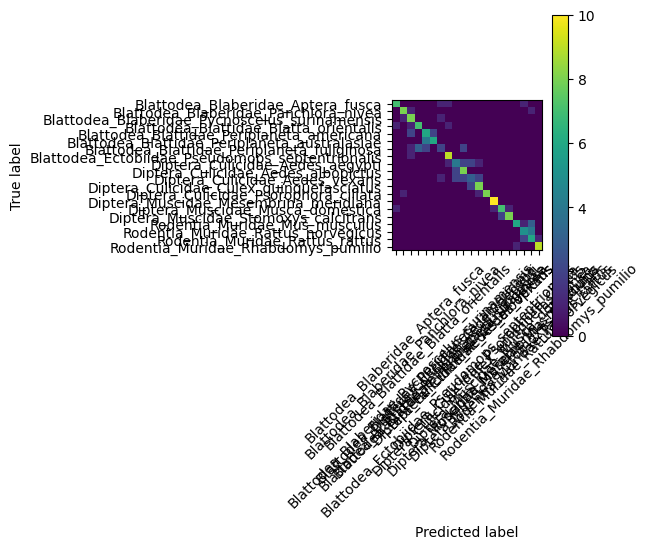

In [27]:
# Cell 6 — confusion-matrix + per-class accuracy on the val split
import torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in val_dl:
        logits = model(imgs.to(DEVICE))
        y_true.append(labels)
        y_pred.append(logits.argmax(1).cpu())
y_true = torch.cat(y_true).numpy()
y_pred = torch.cat(y_pred).numpy()

# overall metrics
acc = (y_true == y_pred).mean()
print(f"Validation accuracy: {acc:.3%}")

# per-class accuracy
per_class = (
    pd.Series(y_true)
        .groupby(y_true)
        .size()
        .rename("total")
        .to_frame()
        .assign(correct = pd.Series(y_true[y_true == y_pred]).groupby(y_true[y_true == y_pred]).size())
        .fillna(0)
)
per_class["acc"] = round(per_class["correct"] / per_class["total"], 3)
per_class["name"] = per_class.index.map(idx_to_class) # idx_to_class from Cell 3
per_class = per_class[["name", "total", "acc"]].sort_values("acc")
display(per_class) # Jupyter will show a nice table

# Confusion matrix (optional but handy)
cm = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(cm, display_labels=[idx_to_class[i] for i in range(num_classes)]
).plot(include_values=False, ax=ax, xticks_rotation=45)
plt.tight_layout() ; plt.show()